In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, rgb2hex
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'



from skimage.io import imread
import scipy
from skimage.morphology import binary_erosion, binary_dilation, medial_axis, disk, medial_axis,remove_small_holes,remove_small_objects
import skfmm
import cv2

import fastremap #important for relabeling! Could move just to color function perhaps, but idk of other parts of cellpose require sequential lebel matrices; probably worth it


from cellpose import models, io, dynamics, plot, transforms, omnipose
from cellpose.omnipose import utils
from cellpose.omnipose.utils import rescale

## Run tests
Toggle the if statement to turn on the synthetic cell benchmark 

circle_r149
Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (302, 302)
Loaded values are of type: bool
Mask has mean diameter: 191.9282455444336


(-0.5, 301.5, 301.5, -0.5)

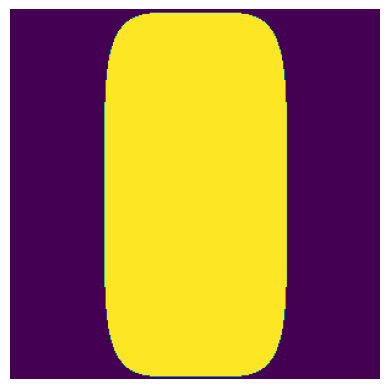

In [20]:
name = 'cell_4243'
maskdir = '/home/kcutler/DataDrive/omnipose_paper/Figure 3/' + name + '_mask.png'

masks = imread(maskdir).astype(np.uint16)
if len(masks.shape)>2:
    masks, remap = fastremap.renumber(masks[:,:,1])

if 1: #toggle synthetic 
    l = 300
    n = 1
    a = 5
    b = .5
    r = l/2-1
    x, y = np.indices((l, l))
    center = (l/2, l/2)
    circle = np.abs(x - center[0])**a + np.abs((y - center[1])/b)**a < r**a
    masks = np.pad(circle,pad)
    name = 'circle_r'+'%.0f'%r


print(name)
basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure S5/'
d = omnipose.core.diameters(masks)
print("Loaded array is of type:", type(masks))
print("Loaded array has shape:", masks.shape)
print("Loaded values are of type:", masks.dtype)
print("Mask has mean diameter:", d)
plt.imshow(masks)
plt.axis('off')

In [21]:
from numba import njit, float32, int32, vectorize

# In each case, I used finite-difference substitutions in the PDEs and solved for the central lattice point. 
# Faster/smoother results when using a 5-point template and a rotated one (scaled by sqrt(2)), averaged geometrically. 
@njit('(float64[:], int64[:], int64[:], int64[:], int64[:], int32, float64, types.unicode_type)', nogil=True)
def _extend_centers(T, y, x, ymed, xmed, Lx, value=1,method=''):
    diff = 1
    niter = 0
    diffs = []
    while diff>1e-16:
        old = T[y*Lx + x].copy()
        if method == 'area_heat':
            a = 1
            A = (a + T[(y-1)*Lx + x] + T[(y+1)*Lx + x] + T[y*Lx + x-1] + T[y*Lx + x+1]) / 4
            B = (a*np.sqrt(2) + T[(y-1)*Lx + x+1]+T[(y+1)*Lx + x-1]+T[(y-1)*Lx + x-1]+T[(y+1)*Lx + x+1]) / 4
            T[y*Lx + x] = np.sqrt(A*B)
        elif method == 'screened_poisson':
            #solve screened poisson equation laplacian(T)-(b**2)T = -a
            a = 1 
            b = 1
            A = (a + T[(y-1)*Lx + x] + T[(y+1)*Lx + x] + T[y*Lx + x-1] + T[y*Lx + x+1] )/(4+b**2)
            B = (a*np.sqrt(2) + T[(y-1)*Lx + x+1]+T[(y+1)*Lx + x-1]+T[(y-1)*Lx + x-1]+T[(y+1)*Lx + x+1]) / (4+(b**2)*np.sqrt(2))
            T[y*Lx + x] = np.sqrt(A*B)
            
        elif method == 'distance':
            #solve eikonal equation |grad(T)|=1
            minx = np.minimum(T[y*Lx + x-1],T[y*Lx + x+1])
            miny = np.minimum(T[(y-1)*Lx + x],T[(y+1)*Lx + x],)
            mina = np.minimum(T[(y-1)*Lx + x-1],T[(y+1)*Lx + x+1])
            minb = np.minimum(T[(y-1)*Lx + x+1],T[(y+1)*Lx + x-1])
            A = np.where(np.abs(mina-minb) >= 2, np.minimum(mina,minb)+np.sqrt(2), (1./2)*(mina+minb+np.sqrt(4-(mina-minb)**2)))
            B = np.where(np.abs(miny-minx) >= np.sqrt(2), np.minimum(miny,minx)+1, (1./2)*(miny+minx+np.sqrt(2-(miny-minx)**2)))
            T[y*Lx + x] = np.sqrt(A*B)
        
        niter+=1
        diff = np.mean(np.abs(T[y*Lx + x]-old))
        diffs.append(diff)

    return T, niter, diffs


In [22]:
methods = ['area_heat','screened_poisson','distance']
pad = 1
mask = np.pad(masks.copy(),pad)
Ly, Lx = mask.shape
Y, X = np.nonzero(mask)
value = 1.
J = len(methods)
heat = [[]]*J
niter = [[]]*J
diff = [[]]*J
for j in range(J):
    T = np.zeros((Ly)*(Lx), np.float64)
    heat[j],niter[j],diff[j] = _extend_centers(T, Y, X, Y, X, Lx, value=value, method=methods[j])
    print(niter[j])

146419
137
104


In [23]:
with open(basedir+name+'_niter.txt', "w") as text_file:
    print(f" methods: {methods}"+f" iterations: {niter}", file=text_file)

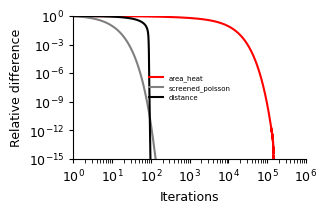

In [24]:
mpl.rcParams.update(mpl.rcParamsDefault)
axcol = 'k'
background_color = np.array([1,1,1,1])
golden = (1 + 5 ** 0.5) / 2
sz = 3
labelsize = 9
colors = ['r','gray','k']
fig,ax = plt.subplots(figsize=(sz,sz/golden))
for j in range(J):
    ax.plot(np.divide(diff[j],diff[j][1]),label=methods[j],color=colors[j])
#     ax.plot(np.diff(diff[j])/diff[j][1:],label=methods[j])
                               
ax.set_ylim(1e-15,1)
ax.set_xlim(1,1e6)
ax.set_xscale('log')
ax.set_yscale('log')
x_major = mpl.ticker.LogLocator(base = 10.0, numticks = 10)
ax.xaxis.set_major_locator(x_major)
x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 6)
ax.yaxis.set_major_locator(y_major)
# y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
# ax.yaxis.set_minor_locator(y_minor)
# ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.legend(prop={'size': 5}, loc='best', frameon=False)
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)
ax.set_ylabel('Relative difference', fontsize = labelsize)
ax.set_xlabel('Iterations', fontsize = labelsize)
plt.show()

fig.savefig(basedir + name +'_convergence_test.pdf',bbox_inches='tight')

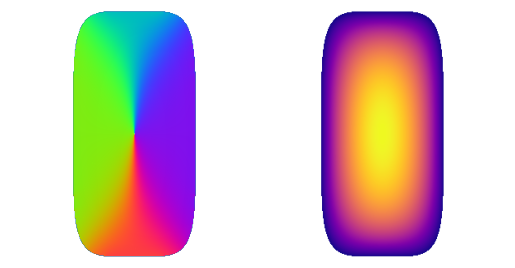

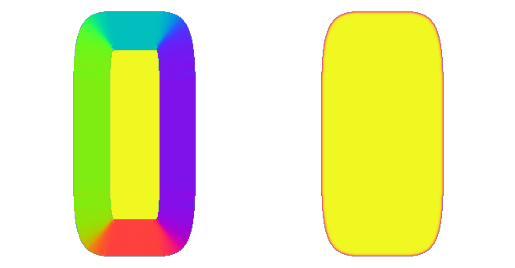

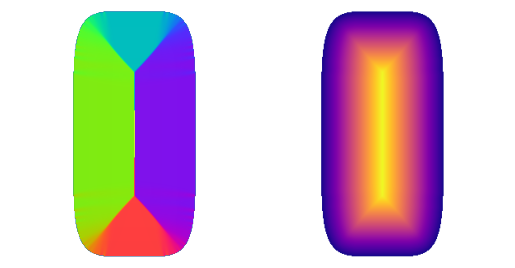

In [25]:
y, x = np.nonzero(mask)
Ly,Lx = mask.shape
flows = [[]]*J
color_heat = [[]]*J
cmap = mpl.cm.get_cmap('plasma')

basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure S5/'
io.check_dir(basedir)

for j in range(J):
    dy = np.zeros(Ly*Lx, np.float64) 
    dx = np.zeros(Ly*Lx, np.float64)
    T = heat[j].copy()
    dy[y*Lx + x] = T[(y+1)*Lx + x] - T[(y-1)*Lx + x]
    dx[y*Lx + x] = T[y*Lx + x+1] - T[y*Lx + x-1]
    mu = transforms.normalize_field(np.stack((dy,dx)))
    # mu = np.stack((dy,dx))
    # T[Y*Lx+X] = laplacian2(T, Y, X, Lx)
    T.shape = (Ly,Lx)
    mu.shape = (2,Ly,Lx)
    T = T[pad:-pad,pad:-pad]
    mu = mu[:,pad:-pad,pad:-pad]
    flows[j] = plot.dx_to_circ(mu,transparency=True)

    pic = cmap(rescale(T))
    pic[:,:,-1] = masks>0
    plt.imshow(pic)
    color_heat[j] = pic
    plt.imshow(np.hstack((flows[j],pic)))
    plt.axis('off')
    plt.show()
    
    skimage.io.imsave(basedir + name +'_8bit_potential_' + methods[j] + '.png',((pic)*255).astype(np.uint8))
    skimage.io.imsave(basedir + name +'_8bit_flow_' + methods[j] + '.png',((flows[j])*255).astype(np.uint8))